## 1. Comprendre les embeddings de mots


Les modèles de deep learning, comme les LLMs, ne peuvent pas traiter du texte brute directement. Ce n'est pas compatible avec les opérations mathématiques utilisés pour les entrainements. Il faut transformer les mots dans un espace vectoriel continue.

Le concept de transfromer des données en un vecteur est souvent appelé : **embedding**.

Plusieurs algorithmes ont été développé pour generer des embeddings de mots. Un de plus connus est l'approche **Word2Vec**.
Le principe est d'entrainer un réseau de neurones à générer des embeddings de mots en prédisant le context d'un mot à partir d'un mot cible ou vice versa. L'idée principale est que les mots qui apparaissent  dasn des contextes similaires doivent avoir des sens simimaires.

Les embeddings de mots peuvent avoir des dimenssions variables, d'une à des centaines.

Plutôt qu'utiliser un algorithme comme Word2Vec, **la plupart des LLMs générent leurs propres embeddings qui font partis de la couche d'entrée et qui est mise à jour durant l'entrainement**.
Cela permet d'optimiser la création d'embeddings durant l'entrainement pour la tache spécifique et les données.


## 2. Tokenisation de texte

Nous allons commencer par séparer le texte en tokens. Ces tokens sont soit des mots individuels ou des caractères spéciaux dont les caractères de ponctuation.

In [40]:
# On télécharge le texte d'example
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

# On récupère le texte du fichier
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()
print("Total number of character:", len(raw_text))

Total number of character: 20479


On va séparer le texte en liste de tokens :
* On va séparer les mots avec les espaces et signes de ponctuation.
* On ne met pas tous les texte en minuscule, car les lettres pacitales aident le LLM à distinguer les noms propres et communs par exemples.
* Pour l'exemple, on supprime les espaces, mais **il peut être important de les garder si on entraine des modèle sensibles à la structure du texte** comme du code.

In [41]:
# On sépare le texte en une liste de tokens (sans les espaces pour l'exemple)
import re

text = "Hello, world. This, is a test."
result = re.split(r'([,.]|\s)', text)
result = [item for item in result if item.strip()]
print(result)

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']
4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


## 3. Convertir les tokens en token IDs

Il faut maitrenant convertir ces strings python en représentation sous forme d'entier.

Pour faire cela, il faut commencer par construire un vocabulaire. Ce vocabulaire va définit comment on fait correspondre un mot unique et un caractère spécial vers un entier unique.

In [42]:
# Création de la liste du vocabulaire
all_words = sorted(set(preprocessed))
vocab = {token:integer for integer,token in enumerate(all_words)}
print("Vocab size :", len(all_words))
print("Vocab :", vocab)

Vocab size : 1130
Vocab : {'!': 0, '"': 1, "'": 2, '(': 3, ')': 4, ',': 5, '--': 6, '.': 7, ':': 8, ';': 9, '?': 10, 'A': 11, 'Ah': 12, 'Among': 13, 'And': 14, 'Are': 15, 'Arrt': 16, 'As': 17, 'At': 18, 'Be': 19, 'Begin': 20, 'Burlington': 21, 'But': 22, 'By': 23, 'Carlo': 24, 'Chicago': 25, 'Claude': 26, 'Come': 27, 'Croft': 28, 'Destroyed': 29, 'Devonshire': 30, 'Don': 31, 'Dubarry': 32, 'Emperors': 33, 'Florence': 34, 'For': 35, 'Gallery': 36, 'Gideon': 37, 'Gisburn': 38, 'Gisburns': 39, 'Grafton': 40, 'Greek': 41, 'Grindle': 42, 'Grindles': 43, 'HAD': 44, 'Had': 45, 'Hang': 46, 'Has': 47, 'He': 48, 'Her': 49, 'Hermia': 50, 'His': 51, 'How': 52, 'I': 53, 'If': 54, 'In': 55, 'It': 56, 'Jack': 57, 'Jove': 58, 'Just': 59, 'Lord': 60, 'Made': 61, 'Miss': 62, 'Money': 63, 'Monte': 64, 'Moon-dancers': 65, 'Mr': 66, 'Mrs': 67, 'My': 68, 'Never': 69, 'No': 70, 'Now': 71, 'Nutley': 72, 'Of': 73, 'Oh': 74, 'On': 75, 'Once': 76, 'Only': 77, 'Or': 78, 'Perhaps': 79, 'Poor': 80, 'Professional': 

In [43]:
class SimpleTokenizerV1:
  def __init__(self, vocab):
    """Classe pour notre tokenizer."""
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}

  def encode(self, text):
    """Sépare le texte en tokens et créé la liste des IDs des tokens"""
    preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
    preprocessed = [
      item.strip() for item in preprocessed if item.strip()
    ]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  def decode(self, ids):
    """Donne la correpondance inbverse pour convertir les tokens IDs en texte."""
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [44]:
# On instancie notre tokenizer
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last he painted, you know, Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 67, 7, 38, 851, 1108, 754, 793, 7]
" It' s the last he painted, you know, Mrs. Gisburn said with pardonable pride.


## 4. Ajout de tokens spéciaux

* Il faut modifier le tokenizer pour gérer les mots inconnus (non présents dans le vocabulaire)
* Il faut aussi ajouter un token pour marquer les limites des documents.

In [45]:
# On ajoute les 2 nouveaux tokens spéciaux
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1132


In [46]:
class SimpleTokenizerV2:
  def __init__(self, vocab):
    """Classe pour notre tokenizer."""
    self.str_to_int = vocab
    self.int_to_str = {i:s for s,i in vocab.items()}

  def encode(self, text):
    """Sépare le texte en tokens et créé la liste des IDs des tokens"""
    preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
    preprocessed = [
      item.strip() for item in preprocessed if item.strip()
    ]
    # On remplace les mots inconnus par <|unk|>
    preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
    ids = [self.str_to_int[s] for s in preprocessed]
    return ids

  def decode(self, ids):
    """Donne la correpondance inbverse pour convertir les tokens IDs en texte."""
    text = " ".join([self.int_to_str[i] for i in ids])
    text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
    return text

In [47]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
tokenizer = SimpleTokenizerV2(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


Selon les LLMs, d'autres tokens spéciaux peuvent être ajouté :
* [BOS] (begining of sequence) : token qui marque le début du texte.
* [EOS] (end of sequence) : token positionné à la fin d'un texte et qui est utile quand on concatènede multiple textes non relié.
* [PAD] (padding) : Quand le LLM est entrainé, un batch peut contenir des textes de taille variable. Pour s'assurer que tous les textes aient la même longueur, les textes plus courts sont étendusavec le token de padding.

## 5. Byte pair encoding

Le tokenizer BPE a été utilisé pour entrainer des LLMs comme GPT-2, GPT-3 et le modèle original utilisé dans ChatGPT.

Comme l'implémentation de BPE peut être complexe, on va utiliser tiktoken qui a implémenté l'algorithme BPE de façon efficace en Rust.

Le tokenizer BPE utilisé pour les modèles GPT a un vocabulaire de taille 50257.

Le tokenizer BPE peut aussi gérer les mots inconnus sans token <unk>.
L'algorithme derrière BPE va casser les mots qui ne sont pas dans le vocabulaire en sous mots-mots ou même des caractères individuels, ce qui lui permet de gérer les mots hors vocabulaire.

Pour construire son vocabulaire, BPE va ittérativement regroupé les caractères fréquentys en sous-mots et les sous-mots fréquents en mots. Par exemple, il va commencer par ajouter tous les caractères individuels dans son vocabulaire (a, b, etc.). Ensuite, il va regrouper les combinaisons de caractères qui apparissent fréquemment en sous-mots (d et e => 'de' qui est fréquent dans de nombreux mots anglais). Les regroupements sont déterminés par fréquence.

In [48]:
!pip install tiktoken
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.8.0


In [49]:
# On instancie le tokenizer BPE
tokenizer = tiktoken.get_encoding("gpt2")

text = ("Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.")
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


## 6. Data sampling with sliding window

La prochaine étape dans la création d'embedding pour le LLM est de générer les paires entrée/cible.

Les LLMs sont entrainés en prédisant le mot suivant dans un texte. On va créer un data loader qui va fournir les paires entrée/cible du dataset d'entrainement en utilisant une approche de fenetre glissante.

In [50]:
# On tokenise le texte avec le tokenizer BPE
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

5145


In [51]:
# On garde les 50 premiers tokens pour l'exemple
enc_sample = enc_text[50:]

# Les cibles sont les entrées décalés de 1
context_size = 4
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

[290] ----> 4920
 and ---->  established
[290, 4920] ----> 2241
 and established ---->  himself
[290, 4920, 2241] ----> 287
 and established himself ---->  in
[290, 4920, 2241, 287] ----> 257
 and established himself in ---->  a


In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
    """Création du dataset pour regrouper les entrées et cibles.
    Args:
      stride: Décalage entre les entrées
    """
    self.input_ids = []
    self.target_ids = []
    # Tokenisation du texte
    token_ids = tokenizer.encode(txt)
    # Sliding window pour séparer le texte en séquence de taille max_length
    for i in range(0, len(token_ids) - max_length, stride):
      input_chunk = token_ids[i:i + max_length]
      target_chunk = token_ids[i + 1: i + max_length + 1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    """Retourne le nb de lignes du dataset."""
    return len(self.input_ids)

  def __getitem__(self, idx):
    """Retourne une ligne du dataset."""
    return self.input_ids[idx], self.target_ids[idx]

In [53]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
  """Data loader pour générer des batchs avec des paires entrée/cible."""
  tokenizer = tiktoken.get_encoding("gpt2")
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    drop_last=drop_last,  # Enlève le dernier batch s'il est pas complet
    num_workers=num_workers  # Nb de processus CPU à utiliser pour le traitement
  )
  return dataloader

In [54]:
# Test du data loader
dataloader = create_dataloader_v1(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print("Batch 1 :", first_batch)
second_batch = next(data_iter)
print("Batch 2 :", second_batch)

Batch 1 : [tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]
Batch 2 : [tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


Le paramètre 'stride' permet de définir le décalage en nb de tokens entre les entrées. Augmenter ce paramètre peut permettre d'utiliser le dataset entièrement sans sauter un seul mot. **Cela peut permettre d'éviter les overlap entre les batchs, ce qui augmenterait l'overfitting.**

## 7. Création des embeddings des tokens

Il faut maintenant convertir les IDs des tokens en vecteurs d'embedding :
* On commence par initialiser les poids des embeddings aléatoirement


In [55]:
# Exemple simplifié de conversion token IDs -> embeddings
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print("Poids couche embedding :", embedding_layer.weight)
print("Embedding vecteur d'un token ID :", embedding_layer(torch.tensor([3])))

Poids couche embedding : Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
Embedding vecteur d'un token ID : tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


Les poids de la matrice de la couche d'embedding continet des valauers alétaoires. Ces valeurs sont optimisés durant l'entrainement du LLM.
* Il y a une ligne pour chaque tokens possibles dans le vocabulaire.
* Il y a une colone pour chaque dimenssion des dimenssions de l'embedding.

**La couche d'embedding est essentiellment une opération de recherche qui retourne les lignes de la matrice de poids de la couche d'embedding à partir d'un ID de token.**

In [56]:
# On applique la couche d'embedding sur nostokens IDs
input_ids = torch.tensor([2, 3, 5, 1])
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


## 8. Encoder la position des mots

Un petit problème des LLMs est que leur mécanisme d'auto-attention ne prend pas en compte la position ou l'ordre des tokens dans la séquence.

**La couche d'embedding fonctionne de façon à ce que le même token ID a toujours la mêm représentation vectorielle d'associé, peu importe où le token ID est positionné dans la séquence.**

Il va donc être utile d'injecter une information additionnelle sur la position des tokens.

Il y a deux catégories d'embeddings qui tienne compte de la position :
* *Absolute positional embeddings* : pour chaque position dans la séquence d'entrée, un embedding unique est ajouté à l'embedding du token pour transmettre sa position excat dans la séquence.
* *Relative positional embeddings* : sur la distance entre les tokens, le modèle va apprendre les relations en terme de 'distant à quel point' plutôt que 'à quelle position exacte'. Cela permet au modèle de mieux generaliser sur les séquences de longueurs variables, même s'il n'a pas vu de telles longueurs durant l'entrainement.

**Les modèles GPT d'OpenAI utilise les 'absolute positional embeddings' qui sont optimisés durant l'entrainement plutôt qu'être fixé ou prédéfini comme le 'absolute positional encodings' dans le modèle transformer original.**

In [57]:
# Création des embeddings de position initiales
vocab_size = 50257
output_dim = 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [58]:
# On échantillone les données avec le data loader
max_length = 4
dataloader = create_dataloader_v1(
  raw_text, batch_size=8, max_length=max_length,
  stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


Le batch de données contient 8 échantillons de texte avec 4 tokens chacuns.

In [59]:
# On créé les embeddings pour ces tokens IDs
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


Chaque token ID est maitenant représenté dans un vecteur de dimenssion 256.

Pour l'approche 'absolute embedding' des modèles GPT, il faut créer une autre couche d'embedding de la même dimenssion que celle utiliser pour transfromer les token ID en embeddings.

In [60]:
# Création des positional embeddings
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


Le tensor de positional embedding contient 4 vecteur de dimenssions 256. On peut les ajouter directement aux embedings des tokens

In [61]:
# Somme des tokens embeddings et positional embedding
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


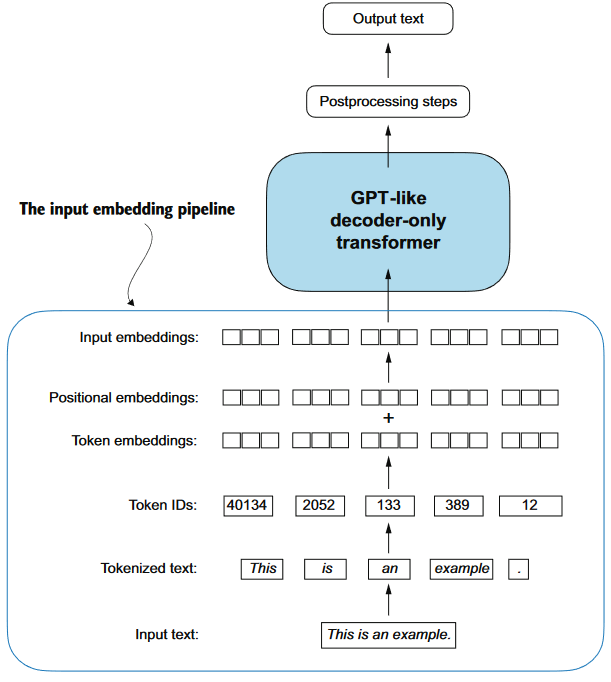